# KCWI_calcs.ipynb

functions from Busola Alabi, Apr 2018

In [26]:
from __future__ import division
import glob
import re
import os, sys
from astropy.io.fits import getheader, getdata
from astropy.wcs import WCS
import astropy.units as u
import numpy as np
from scipy import interpolate
import logging
from time import time
import matplotlib.pyplot as plt
from pylab import *
import matplotlib as mpl
import matplotlib.ticker as mtick
from scipy.special import gamma

In [2]:
def make_obj(flux, grat_wave, f_lam_index):
        '''
        '''
        w = np.arange(3000)+3000.
        p_A = flux/(2.e-8/w)*(w/grat_wave)**f_lam_index

        return w, p_A

def inst_throughput(wave, grat):
        '''
        '''
        eff_bl   = np.asarray([0.1825,0.38,0.40,0.46,0.47,0.44])
        eff_bm   = np.asarray([0.1575, 0.33, 0.36, 0.42, 0.48, 0.45])
        eff_bh1  = np.asarray([0., 0.0, 0.0, 0.0, 0.0, 0.])
        eff_bh2  = np.asarray([0.,  0.18, 0.3, 0.4, 0.28, 0.])
        eff_bh3  = np.asarray([0., 0., 0., 0.2, 0.29, 0.31])
        wave_0   = np.asarray([355.,380.,405.,450.,486.,530.])*10.
        wave_bl  = np.asarray([355., 530.])*10.
        wave_bm  = np.asarray([355., 530.])*10.
        wave_bh1 = np.asarray([350., 450.])*10.
        wave_bh2 = np.asarray([405., 486.])*10.
        wave_bh3 = np.asarray([405., 530.])*10.
        trans_atmtel = np.asarray([0.54, 0.55, 0.56, 0.56, 0.56, 0.55])

        if grat=='BL':
                eff = eff_bl*trans_atmtel
                wave_range = wave_bl

        if grat=='BM':
                eff = eff_bm*trans_atmtel
                wave_range = wave_bm

        if grat=='BH1':
                eff = eff_bh1*trans_atmtel
                wave_range = wave_bh1

        if grat=='BH2':
                eff = eff_bh2*trans_atmtel
                wave_range = wave_bh2

        if grat=='BH3':
                eff = eff_bh3*trans_atmtel
                wave_range = wave_bh3


        wave1 = wave
        interpfunc = interpolate.interp1d(wave_0, eff, fill_value="extrapolate") #this is the only way I've gotten this interpolation to work
        eff_int = interpfunc(wave1)
        idx = np.where((wave1 <= wave_range[0]) | (wave1 > wave_range[1]))
        eff_int[idx] = 0.
        return eff_int



def obj_cts(w, f0, grat, exposure_time):
        '''
        '''
        A_geo = np.pi/4.*(10.e2)**2
        eff = inst_throughput(w, grat)
        cts = eff*A_geo*exposure_time*f0
        return cts

def sky(wave):
        '''
        '''
        with open('mk_sky.dat') as f:
                lines = (line for line in f if not line.startswith('#'))
                skydata = np.loadtxt(lines, skiprows=2)

        ws = skydata[:,0]
        fs = skydata[:,1]
        f_nu_data = getdata('lris_esi_skyspec_fnu_uJy.fits')
        f_nu_hdr = getheader('lris_esi_skyspec_fnu_uJy.fits')
        dw = f_nu_hdr["CDELT1"]
        w0 = f_nu_hdr["CRVAL1"]
        ns = len(fs)
        ws = np.arange(ns)*dw + w0
        f_lam = f_nu_data[:len(ws)]*1e-29*3.*1e18/ws/ws

        interpfunc = interpolate.interp1d(ws,f_lam, fill_value="extrapolate")
        fs_int = interpfunc(wave)
        return fs_int

def sky_mk(wave):
        '''
        '''
        with open('mk_sky.dat') as f:
                lines = (line for line in f if not line.startswith('#'))
                skydata = np.loadtxt(lines, skiprows=2)

        ws = skydata[:,0]
        fs = skydata[:,1]
        f_nu_data = getdata('lris_esi_skyspec_fnu_uJy.fits')
        f_nu_hdr = getheader('lris_esi_skyspec_fnu_uJy.fits')
        dw = f_nu_hdr["CDELT1"]
        w0 = f_nu_hdr["CRVAL1"]
        ns = len(fs)
        ws = np.arange(ns)*dw + w0
        f_lam = f_nu_data[:len(ws)]*1e-29*3.*1e18/ws/ws
        p_lam = f_lam/(2.e-8/ws)

        interpfunc = interpolate.interp1d(ws,p_lam, fill_value="extrapolate") #using linear since argument not set in idl
        ps_int = interpfunc(wave)
        return ps_int

def sky_cts(w, grat, exposure_time, airmass=1.2, area=1.0):
        '''
        '''
        A_geo = np.pi/4.*(10.e2)**2
        eff = inst_throughput(w, grat)
        cts = eff*A_geo*exposure_time*sky_mk(w)*airmass*area
        return cts

In [10]:
def ETC(slicer, grating, grat_wave, f_lam_index, seeing, exposure_time, ccd_bin, spatial_bin=[],
        spectral_bin=None, nas=True, sb=True, mag_AB=None, flux=None, Nframes=1, emline_width=None):


        """
                Parameters
                ==========
            slicer: str
                      L/M/S (Large, Medium or Small)
            grating: str
                      BH1, BH2, BH3, BM, BL
            grating wavelength: float or int
                      3400. < ref_wave < 6000.
                f_lam_index: float
                      source f_lam ~ lam^f_lam_index, default = 0
            seeing: float
                      arcsec
            exposure_time: float
                  seconds for source image (total) for all frames
                ccd_bin: str
                      '1x1','2x2'"
            spatial_bin: list
                      [dx,dy] bin in arcsec x arcsec for binning extended emission flux. if sb=True then default is 1 x 1 arcsec^2'
                spectral_bin: float or int
                      Ang to bin for S/N calculation, default=None
            nas: boolean
                      nod and shuffle
            sb: boolean
                    surface brightness m_AB in mag arcsec^2; flux = cgs arcsec^-2'
            mag_AB: float or int
                      continuum AB magnitude at wavelength (ref_wave)'
                flux: float
                      erg cm^-2 s^-1 Ang^1 (continuum source [total]); erg cm^-2 s^1 (point line source [total]) [emline = width in Ang]
                  EXTENDED: erg cm^-2 s^-1 Ang^1 arcsec^-2 (continuum source [total]); erg cm^-2 s^1 arcsec^-2 (point line source [total]) [emline = width in Ang]
            Nframes: int
                      number of frames (default is 1)
            emline_width: float
                      flux is for an emission line, not continuum flux (only works for flux), and emission line width is emline_width Ang

    """
#       logger = logging.getLogger(__name__)
        logger.info('Running KECK/ETC')
        t0 = time()
        slicer_OPTIONS = ('L', 'M','S')
        grating_OPTIONS = ('BH1', 'BH2', 'BH3', 'BM', 'BL')

        if slicer not in slicer_OPTIONS:
                raise ValueError("slicer must be L, M, or S, wrongly entered {}".format(slicer))
        logger.info('Using SLICER=%s', slicer)

        if grating not in grating_OPTIONS:
                raise ValueError("grating must be L, M, or S, wrongly entered {}".format(grating))
        logger.info('Using GRATING=%s', grating)

        if grat_wave < 3400. or grat_wave > 6000:
                raise ValueError('wrong value for grating wavelength')
        logger.info('Using reference wavelength=%.2f', grat_wave)

        if len(spatial_bin) != 2 and len(spatial_bin) !=0:
                raise ValueError('wrong spatial binning!!')
        logger.info('Using spatial binning, spatial_bin=%s', str(spatial_bin[0])+'x'+str(spatial_bin[1]))


        bin_factor = 1.
        if ccd_bin == '2x2':
                bin_factor = 0.25
        if ccd_bin == '2x2' and slicer == 'S':
                print'******** WARNING: DO NOT USE 2x2 BINNING WITH SMALL SLICER'
        read_noise = 2.7 # electrons
        Nf = Nframes

        chsz = 3 #what is this????
        nas_overhead = 10. #seconds per half cycle
        seeing1 = seeing
        seeing2 = seeing
        pixels_per_arcsec = 1./0.147
        if slicer == 'L':
                seeing2 = 1.38
        snr_spatial_bin = seeing1*seeing2
        pixels_spectral = 8
        arcsec_per_slice = 1.35

        if slicer == 'M':
                seeing2 = max(0.69,seeing)
                snr_spatial_bin = seeing1*seeing2
                pixels_spectral = 4
                arcsec_per_slice = 0.69
        if slicer == 'S':
                seeing2 = seeing
                snr_spatial_bin = seeing1*seeing2
                pixels_spectral = 2
                arcsec_per_slice = 0.35

        N_slices = seeing/arcsec_per_slice

        if len(spatial_bin) == 2:
                N_slices = spatial_bin[1]/arcsec_per_slice
                snr_spatial_bin = spatial_bin[0]*spatial_bin[1]

        pixels_spatial_bin = pixels_per_arcsec * N_slices
        print "GRATING :", grating

        if grating == 'BL':
                A_per_pixel = 0.625

        if grating == 'BM':
                A_per_pixel = 0.28

        if grating == 'BH2' or grating == 'BH3':
                A_per_pixel = 0.125

        print 'A_per_pixel', A_per_pixel

        logger.info('f_lam ~ lam = %.2f',f_lam_index)
        logger.info('SEEING: %.2f, %s', seeing, ' arcsec')
        logger.info('Ang/pixel: %.2f', A_per_pixel)
        logger.info('spectral pixels in 1 spectral resolution element: %.2f',pixels_spectral)

        A_per_spectral_bin = pixels_spectral*A_per_pixel

        logger.info('Ang/resolution element: =%.2f',A_per_spectral_bin)

        if spectral_bin is not None:
                snr_spectral_bin = spectral_bin
        else:
                snr_spectral_bin = A_per_spectral_bin

        logger.info('Ang/SNR bin: %.2f', snr_spectral_bin)
        pixels_per_snr_spec_bin = snr_spectral_bin/A_per_pixel
        logger.info('Pixels/Spectral SNR bin: %.2f', pixels_per_snr_spec_bin)
        logger.info('SNR Spatial Bin [arcsec^2]: %.2f', snr_spatial_bin)
        logger.info('SNR Spatial Bin [pixels^2]: %.2f', pixels_spatial_bin)

        flux1 = 0
        if flux is not None:
           flux1 = flux
        if flux is not None and emline_width is not None:
           flux1 = flux/emline_width
        if flux1 == 0 and emline_width is not None:
                raise ValueError('Dont use mag_AB for emission line')

        if mag_AB is not None:
                flux1 = (10**(-0.4*(mag_AB+48.6)))*(3.e18/grat_wave)/grat_wave

        w, p_A = make_obj(flux1,grat_wave, f_lam_index)

        if sb==False and mag_AB is not None:
                flux_input = ' mag_AB'
                logger.info('OBJECT mag: %.2f, %s', mag_AB,flux_input)

        if sb==True and mag_AB is not None:
                flux_input = ' mag_AB / arcsec^2'
                logger.info('OBJECT mag: %.2f, %s',mag_AB,flux_input)


        if flux is not None and sb==False and emline_width is None:
                flux_input = 'erg cm^-2 s^-1 Ang^-1'
        if flux is not None and sb==False and emline_width is not None:
                flux_input = 'erg cm^-2 s^-1 in '+ str(emline_width) +' Ang'
        if flux is not None and sb and emline_width is None:
                flux_input = 'erg cm^-2 s^-1 Ang^-1 arcsec^-2'
        if flux is not None and sb and emline_width is not None:
                flux_input = 'erg cm^-2 s^-1 arcsec^-2 in '+ str(emline_width) +' Ang'
        if flux is not None:
            logger.info('OBJECT Flux  %.2f, %s',flux,flux_input)
        if emline_width is not None:
                logger.info('EMISSION LINE OBJECT --> flux is not per unit Ang')


        t_exp = exposure_time
        if nas==False:
                c_o = obj_cts(w,p_A,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
                c_s = sky_cts(w,grating,exposure_time,airmass=1.2,area=1.0)*snr_spatial_bin*snr_spectral_bin
                c_r = Nf*read_noise**2*pixels_per_snr_spec_bin*pixels_spatial_bin*bin_factor
                snr = c_o/np.sqrt(c_s+c_o+c_r)


        if nas==True:
                n_cyc = np.floor((exposure_time-nas_overhead)/2./(nas+nas_overhead)+0.5)
                total_exposure = (2*n_cyc*(nas+nas_overhead))+nas_overhead
                logger.info('NAS: Rounding up to ',n_cyc, ' Cycles of NAS for total exposure of',total_exposure,' s')
                t_exp = n_cyc*nas
                c_o = obj_cts(w,p_A,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
                c_s = sky_cts(w,grating,t_exp,airmass=1.2,area=1.0)*snr_spatial_bin*snr_spectral_bin
                c_r = 2.*Nf*read_noise**2*pixels_per_snr_spec_bin*pixels_spatial_bin*bin_factor
                snr = c_o/np.sqrt(2.*c_s+c_o+c_r)


        fig=figure(num=1, figsize=(12, 16), dpi=80, facecolor='w', edgecolor='k')
        subplots_adjust(hspace=0.001)

        ax0 = fig.add_subplot(611)
        ax0.plot(w, snr, 'k-')
        ax0.minorticks_on()
        ax0.tick_params(axis='both',which='minor',direction='in', length=5,width=2)
        ax0.tick_params(axis='both',which='major',direction='in', length=8,width=2,labelsize=8)
        ylabel('SNR / %.1f'%snr_spectral_bin+r'$\rm \ \AA$', fontsize=12)

        ax1 = fig.add_subplot(612)
        ax1.plot(w,c_o, 'k--')
        ax1.minorticks_on()
        ax1.tick_params(axis='both',which='minor',direction='in',length=5,width=2)
        ax1.tick_params(axis='both',which='major',direction='in',length=8,width=2,labelsize=12)
        ylabel('Obj cts / %.1f'%snr_spectral_bin+r'$\rm \ \AA$', fontsize=12)

        ax2 = fig.add_subplot(613)
        ax2.plot(w,c_s, 'k--')
        ax2.minorticks_on()
        ax2.tick_params(axis='both',which='minor',direction='in', length=5,width=2)
        ax2.tick_params(axis='both',which='major',direction='in', length=8,width=2,labelsize=12)
        ylabel('Sky cts / %.1f'%snr_spectral_bin+r'$\rm \ \AA$', fontsize=12)

        ax3 = fig.add_subplot(614)
        ax3.plot(w,c_r*np.ones(len(w)), 'k--')
        ax3.minorticks_on()
        ax3.tick_params(axis='both',which='minor', direction='in', length=5,width=2)
        ax3.tick_params(axis='both',which='major', direction='in', length=8,width=2,labelsize=12)
        ylabel('Rd. Noise cts / %.1f'%snr_spectral_bin+r'$\rm \ \AA$', fontsize=12)

        ax4 = fig.add_subplot(615)
        yval = w[c_s > 0]
        num = c_o[c_s > 0]
        den = c_s[c_s > 0]
        ax4.plot(yval, num/den, 'k--')  #some c_s are zeros
        ax4.minorticks_on()
        xlim(min(w), max(w)) #only show show valid data!
        ax4.tick_params(axis='both',which='minor', direction='in', length=5,width=2)
        ax4.tick_params(axis='both',which='major', direction='in', length=8,width=2,labelsize=12)
        ylabel('Obj/Sky cts /%.1f'%snr_spectral_bin+r'$\rm \ \AA$', fontsize=12)


        ax5 = fig.add_subplot(616)
        ax5.plot(w,p_A, 'k--')
        ax5.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
        ax5.minorticks_on()
        ax5.tick_params(axis='both',which='minor',direction='in', length=5,width=2)
        ax5.tick_params(axis='both',which='major',direction='in', length=8,width=2,labelsize=12)

        ylabel('Flux ['r'$\rm ph\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=12)
        xlabel('Wavelength ['r'$\rm \AA$]', fontsize=12)

        show()
        fig.savefig('{}.pdf'.format('KCWI_ETC_calc'), format='pdf', transparent=True, bbox_inches='tight')
        logger.info('KCWI/ETC run successful!')

In [4]:
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)
logger = logging.getLogger(__name__)

In [19]:
if __name__ == '__main__':

    print("KCWI/ETC...python version")

KCWI/ETC...python version


Simulate DF44 observation, begin by figuring out Sérsic model conversions.  
See toy_jeans4.ipynb for more detailed Sérsic calculations.

In [34]:
# n, R_e, M_g = 0.85, 7.1, 19.05 # van Dokkum+16 (van Dokkum+17 is slightly different)
n, mu_0, a_e, R_e = 0.94, 24.2, 9.7, 7.9 # van Dokkum+17; some guesses
b_n = 1.9992*n - 0.3271
mu_m_e = mu_0 - 2.5*log10(n*exp(b_n)/b_n**(2.0*n)*gamma(2.0*n)) + 2.5*b_n / log(10.0) # mean SB, using Graham & Driver eqns 6 and ?
print '<mu>_e =', mu_m_e

<mu>_e =  25.2144770968


[INFO] Running KECK/ETC
[INFO] Using SLICER=M
[INFO] Using GRATING=BM
[INFO] Using reference wavelength=5110.00
[INFO] Using spatial binning, spatial_bin=14.0x14.0
GRATING : BM
A_per_pixel 0.28
[INFO] f_lam ~ lam = 0.00
[INFO] SEEING: 0.75,  arcsec
[INFO] Ang/pixel: 0.28
[INFO] spectral pixels in 1 spectral resolution element: 4.00
[INFO] Ang/resolution element: =1.12
[INFO] Ang/SNR bin: 1.12
[INFO] Pixels/Spectral SNR bin: 4.00
[INFO] SNR Spatial Bin [arcsec^2]: 196.00
[INFO] SNR Spatial Bin [pixels^2]: 138.03
[INFO] OBJECT mag: 25.20,  mag_AB / arcsec^2


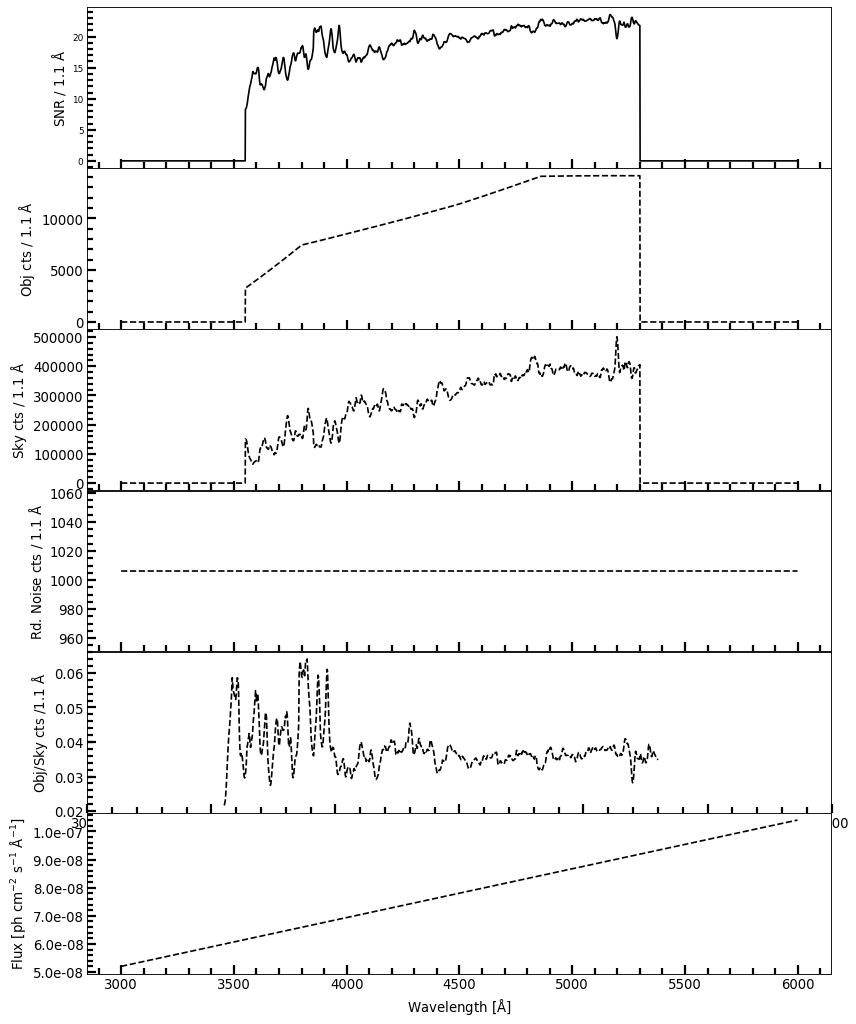

[INFO] KCWI/ETC run successful!


In [32]:
ETC('M','BM', 5110., 0., 0.75, 3600., '2x2', spatial_bin=[14.0,14.0], spectral_bin=None, nas=False, sb=True, mag_AB=25.2, flux=None, Nframes=1, emline_width=None)
# S/N ~ 20/Ang, binned over ~1 R_e aperture

Simulate VCC 1287 observation:

In [41]:
n, a_e, q, m_i = 0.6231, 46.34, 0.809, 15.1081 # Viraj Pandya sci_gf_i.fits header GALFIT results, sent 19 Mar 2018
R_e = a_e * sqrt(q)
g_i = 0.72 # note this is a CFHT g-i not SDSSS g-i
mu_m_e = m_i + 2.5*log10(2.0) + 2.5*log10(pi*R_e**2)
print '<mu>_e (i-band) =', mu_m_e
mu_m_e += g_i
print '<mu>_e (g-band) =', mu_m_e
b_n = 1.9992*n - 0.3271
mu_0 = mu_m_e + 2.5*log10(n*exp(b_n)/b_n**(2.0*n)*gamma(2.0*n)) - 2.5*b_n / log(10.0) # mean SB, using Graham & Driver eqns 6 and ?
print 'mu_0 (g-band) =', mu_0

<mu>_e (i-band) = 25.2032011222
<mu>_e (g-band) = 25.9232011222
mu_0 (g-band) = 25.4187233699


[INFO] Running KECK/ETC
[INFO] Using SLICER=M
[INFO] Using GRATING=BM
[INFO] Using reference wavelength=5092.00
[INFO] Using spatial binning, spatial_bin=16.5x20.4
GRATING : BM
A_per_pixel 0.28
[INFO] f_lam ~ lam = 0.00
[INFO] SEEING: 0.75,  arcsec
[INFO] Ang/pixel: 0.28
[INFO] spectral pixels in 1 spectral resolution element: 4.00
[INFO] Ang/resolution element: =1.12
[INFO] Ang/SNR bin: 1.12
[INFO] Pixels/Spectral SNR bin: 4.00
[INFO] SNR Spatial Bin [arcsec^2]: 336.60
[INFO] SNR Spatial Bin [pixels^2]: 201.12
[INFO] OBJECT mag: 25.50,  mag_AB / arcsec^2


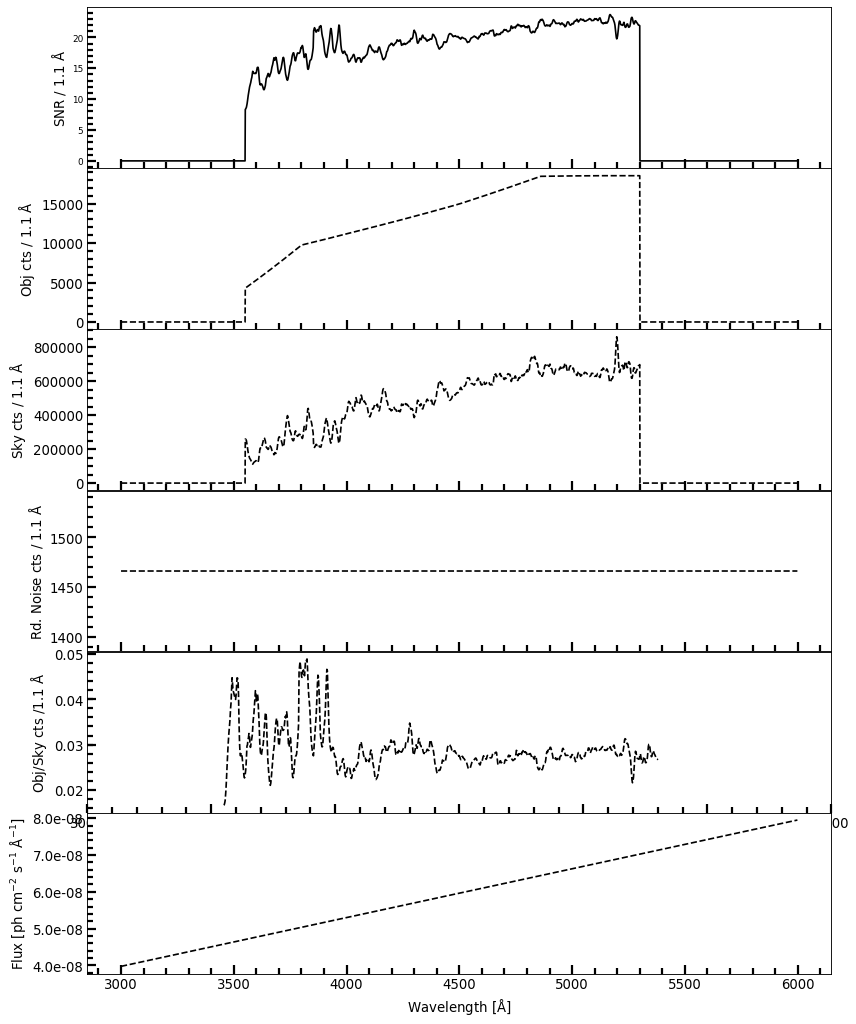

[INFO] KCWI/ETC run successful!


In [42]:
ETC('M','BM', 5092., 0., 0.75, 3600., '2x2', spatial_bin=[16.5,20.4], spectral_bin=None, nas=False, sb=True, mag_AB=25.5, flux=None, Nframes=1, emline_width=None)
# S/N ~ 20/Ang, binned over full FOV

Simulate Hubble VII observation:

<mu_V>_e =  17.5666622181
box size = 1.595208 arcsec
[INFO] Running KECK/ETC
[INFO] Using SLICER=S
[INFO] Using GRATING=BM
[INFO] Using reference wavelength=4500.00
[INFO] Using spatial binning, spatial_bin=1.59520846581x1.59520846581
GRATING : BM
A_per_pixel 0.28
[INFO] f_lam ~ lam = 0.00
[INFO] SEEING: 0.75,  arcsec
[INFO] Ang/pixel: 0.28
[INFO] spectral pixels in 1 spectral resolution element: 2.00
[INFO] Ang/resolution element: =0.56
[INFO] Ang/SNR bin: 0.56
[INFO] Pixels/Spectral SNR bin: 2.00
[INFO] SNR Spatial Bin [arcsec^2]: 2.54
[INFO] SNR Spatial Bin [pixels^2]: 31.01
[INFO] OBJECT mag: 17.57,  mag_AB / arcsec^2


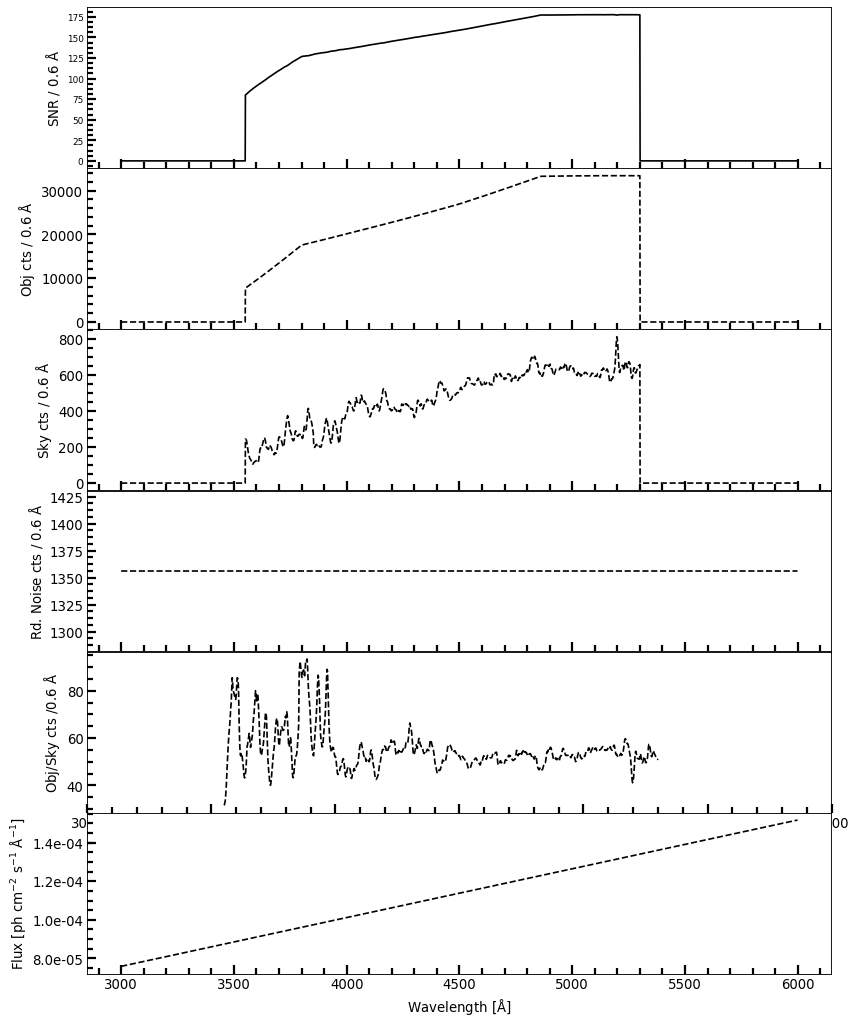

[INFO] KCWI/ETC run successful!


In [18]:
R_e = 0.9
m_V = 15.8
mue = 15.8 + 2.5*log10(2) + 2.5*log10(pi*R_e**2)
print '<mu_V>_e = ', mue
side = sqrt(pi * R_e**2)
print 'box size = %f arcsec' % (side)
ETC('S','BM', 4500., 0., 0.75, 900., '1x1', spatial_bin=[side,side], spectral_bin=None, nas=False, sb=True, mag_AB=mue, flux=None, Nframes=3, emline_width=None)